# Tutorial CV2 - Classification with a squeezing feature map

In this tutorial we implement the squeezing feature map together with the "implicit" linear classifier inspired by Schuld and Killoran (arXiv:1803.07128). 

### Imports

We import openqml, openqml's numpy as well as an optimizer. 

*Note: For convenience, we use openqml's numpy library for all numpy processing. Strictly speaking, one only needs this library for numpy operations inside the cost function or functions called therein, and can use numpy imported via the usual `import numpy as np` everywhere else.*

In [1]:
import openqml as qm
from openqml import numpy as np
from openqml.optimize import GradientDescentOptimizer

The device is the StrawberryFields simulator with two quantum modes or "wires".

In [2]:
dev = qm.device('strawberryfields.fock', wires=2, cutoff_dim=10)

### Quantum node

The variational circuit which defines the quantum node consists of two parts. First, the input is "encoded into Hilbert space" by a squeezing feature map.

In [3]:
def featuremap(x):

    qm.Squeezing(1.5, x[0], [0])
    qm.Squeezing(1.5, x[1], [0])

Next, a layered circuit serves as a trainable linear classifier in Hilbert space. A single layer is defined as:

In [4]:
def layer(w):

    qm.Beamsplitter(w[0], w[1], [0, 1])

    # linear gates in quadrature
    qm.Displacement(w[2], 0., [0])
    qm.Displacement(w[3], 0., [1])

    # quadratic gates in quadrature
    qm.QuadraticPhase(w[4], [0])
    qm.QuadraticPhase(w[5], [1])

    # cubic gates in quadrature
    qm.CubicPhase(w[6], [0])
    qm.CubicPhase(w[7], [1])


The variational circuit in the quantum node first encodes the input via the feature map and then executes the layers. The output is the expectation of the photon number in the first mode.

In [5]:
@qm.qnode(dev)
def qclassifier(weights, x=None):

    # execute feature map
    featuremap(x)

    # execute linear classifier
    for w in weights:
        layer(w)

    return qm.expval.PhotonNumber(0)

### Objective

As an objective we take the square loss between target labels and model predictions. To check the quality of the classifier, we also define the accuracy, or the share of correctly classified samples.

In [6]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l-p)**2
    loss = loss/len(labels)

    return loss


def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l-p) < 1e-5:
            loss += 1
    loss = loss/len(labels)

    return loss

In the cost function we compute the outputs from the variational circuit and compute the square loss.

In [7]:
def cost(weights, X, Y):

    outpts = [qclassifier(weights, x=x) for x in X]

    loss = square_loss(Y, outpts)

    return loss


### Optimization

We load data samples from the moons data set and split it into a training and validation set.

In [8]:
# load function data
data = np.loadtxt("moons.txt")
X = data[:, 0:2]
Y = data[:, -1]

# split into training and validation set
num_data = len(Y)
num_train = int(0.5*num_data)
index = np.random.permutation(range(num_data))
X_train = X[index[: num_train]]
Y_train = Y[index[: num_train]]
X_val = X[index[num_train: ]]
Y_val = Y[index[num_train: ]]

Let's plot the data.

*Note: For the next cell to work you need python's matplotlib library.* 

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X_train[:,0][Y_train==0], X_train[:,1][Y_train==0], marker='o', color='green', label='train 0')
plt.scatter(X_val[:,0][Y_val==0], X_val[:,1][Y_val==0], marker='^', color='green', label='validation 0')
plt.scatter(X_train[:,0][Y_train==1], X_train[:,1][Y_train==1], marker='^', color='purple', label='train 1')
plt.scatter(X_val[:,0][Y_val==1], X_val[:,1][Y_val==1], marker='o', color='purple', label='validation 1')
plt.xlabel('x1')
plt.ylabel('x2')

plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

The trainable circuit parameters (called variables in PennyLane), are initialized with values sampled from a normal distribution. We use 4 layers.

In [10]:
# initialize weights
num_layers = 4
vars_init = 0.05*np.random.randn(num_layers, 8)

vars_init

array([[-0.00780016, -0.01318971, -0.05528023, -0.00926701,  0.00967461,
         0.12300161, -0.02517163, -0.00559375],
       [ 0.11062958, -0.00276368, -0.04096286,  0.00378923,  0.02925287,
         0.02757426, -0.05036169,  0.0263325 ],
       [-0.05517909, -0.0095554 ,  0.00525995, -0.02626185,  0.10255129,
        -0.03813769, -0.0121489 ,  0.00324524],
       [-0.00085168,  0.09182423, -0.02822648,  0.04603324,  0.01946975,
         0.04737105, -0.05361193, -0.01559399]])

We choose the Adam optimizer and update the weights for 50 steps with a batch size of 5. In every step the accuracy is computed for the entire training set.

In [11]:
o = GradientDescentOptimizer(0.0001)


batch_size = 5
vars = vars_init
for it in range(50):

    # select minibatch of training samples
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_train_batch = X_train[batch_index]
    Y_train_batch = Y_train[batch_index]

    vars = o.step(lambda v: cost(v, X_train_batch, Y_train_batch), vars)

    # Compute predictions on train and validation set
    pred_train = [np.round(qclassifier(vars, x=x_)) for x_ in X_train]
    pred_val = [np.round(qclassifier(vars, x=x_)) for x_ in X_val]
    acc_train = accuracy(Y_train, pred_train)
    acc_val = accuracy(Y_val, pred_val)

    print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
          "".format(it+1, cost(vars, X_train_batch, Y_train_batch), acc_train, acc_val))

Iter:     1 | Cost: 0.2109074 | Acc train: 0.5200000 | Acc validation: 0.6200000 
Iter:     2 | Cost: 0.2387016 | Acc train: 0.5200000 | Acc validation: 0.6200000 
Iter:     3 | Cost: 0.2817764 | Acc train: 0.5200000 | Acc validation: 0.6200000 
Iter:     4 | Cost: 0.2949667 | Acc train: 0.5200000 | Acc validation: 0.6200000 
Iter:     5 | Cost: 0.2803269 | Acc train: 0.5200000 | Acc validation: 0.6200000 
Iter:     6 | Cost: 0.3037542 | Acc train: 0.5200000 | Acc validation: 0.6200000 
Iter:     7 | Cost: 0.3655550 | Acc train: 0.5200000 | Acc validation: 0.6200000 
Iter:     8 | Cost: 0.3101475 | Acc train: 0.5200000 | Acc validation: 0.6200000 
Iter:     9 | Cost: 0.2318217 | Acc train: 0.5200000 | Acc validation: 0.6200000 
Iter:    10 | Cost: 0.1770130 | Acc train: 0.5200000 | Acc validation: 0.6200000 
Iter:    11 | Cost: 0.2350665 | Acc train: 0.5200000 | Acc validation: 0.6200000 
Iter:    12 | Cost: 0.2889203 | Acc train: 0.5200000 | Acc validation: 0.6200000 
Iter:    13 | Co

With the last predictions we can plot the classification of the model for the data.

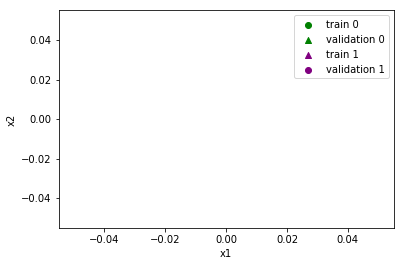

In [12]:
plt.figure()
plt.scatter(X_train[:,0][pred_train==0], X_train[:,1][pred_train==0], marker='o', color='green', label='train 0')
plt.scatter(X_val[:,0][pred_val==0], X_val[:,1][pred_val==0], marker='^', color='green', label='validation 0')
plt.scatter(X_train[:,0][pred_train==1], X_train[:,1][pred_train==1], marker='^', color='purple', label='train 1')
plt.scatter(X_val[:,0][pred_val==1], X_val[:,1][pred_val==1], marker='o', color='purple', label='validation 1')
plt.xlabel('x1')
plt.ylabel('x2')

plt.legend()
plt.show()